# Spatial Data for Reporting

This notebook is used to download and process static data that will used in the 
Tacoma Watershed tool (Stormpiper)

# Setup

In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gp
import ee
import json
from pprint import pprint
import glob
from functools import reduce

## Helper functions

In [2]:
def get_geojson_as_json(base_url, path, outFields=None):
    if outFields is None:
        outFields = '*'
    elif isinstance(outFields, list):
        outFields = ','.join(outFields)
    url = f"{base_url}{path}/query?where=1%3D1&outFields={outFields}&f=geojson"
    response = requests.get(url)
    geojson = json.loads(response.text)
    return geojson

def get_geojson_as_gp(base_url, path, outFields=None):
    if outFields is None:
        outFields = '*'
    elif isinstance(outFields, list):
        outFields = ','.join(outFields)
    url = f"{base_url}{path}/query?where=1%3D1&outFields={outFields}&f=geojson"
    df = gp.read_file(url, driver="GeoJSON")
    return df
    

In [3]:
def gdf_to_ee(gdf):

    # Initialize an empty list to store features
    features = []

    # Iterate over each row in the GeoPandas DataFrame
    for index, row in gdf.iterrows():

        # Create a new Earth Engine feature from the row's geometry and properties
        feature = ee.Feature(ee.Geometry(row['geometry']), row.to_dict())

        # Append the feature to the list of features
        features.append(feature)

    # Create a new Earth Engine FeatureCollection from the list of features
    fc = ee.FeatureCollection(features)
    return(fc)

# Get subbasin Data

In [9]:
base_url = "https://gis.cityoftacoma.org/arcgis/rest/services/"
subbasins_path = "ES/SurfacewaterNetwork/MapServer/41" 
subbasins = get_geojson_as_gp(base_url,subbasins_path,outFields = ['BASINNAME','SUBBASIN'])
subbasins_geojson = get_geojson_as_json(base_url,subbasins_path,outFields = ['BASINNAME','SUBBASIN'])
subbasins.head()

 

,BASINNAME,SUBBASIN,geometry
0,WESTERN SLOPES,WS_03,"POLYGON ((-122.52683 47.25504, -122.52698 47.2..."
1,WESTERN SLOPES,WS_01,"POLYGON ((-122.51714 47.27441, -122.51758 47.2..."
2,FLETT CREEK,FL_03,"POLYGON ((-122.47503 47.20173, -122.47490 47.2..."
3,TIDEFLATS,TF_01,"POLYGON ((-122.42198 47.26224, -122.42210 47.2..."
4,NORTHEAST TACOMA,NE_03,"POLYGON ((-122.38348 47.29529, -122.38389 47.2..."


In [10]:
def overlay_and_summarize(x,by_x,by_y="SUBBASIN",y=subbasins): 
    x = x.to_crs('EPSG:3857')
    y = y.to_crs('EPSG:3857')
    shp_tmp = y.overlay(x, how='intersection')

    shp_tmp['intersected_area'] = shp_tmp.area
    shp_tmp = shp_tmp[[by_x,by_y,'intersected_area']]
    summary = shp_tmp.groupby([by_y,by_x]).sum()
    summary['percent'] = summary['intersected_area'] / summary.groupby(by_y)["intersected_area"].transform('sum')
    return(summary)

def overlay_and_summarize_length(x,by_x,by_y="SUBBASIN",y=subbasins): 
    x = x.to_crs('EPSG:3857')
    y = y.to_crs('EPSG:3857')
    shp_tmp = y.overlay(x, how='intersection',keep_geom_type=False)

    shp_tmp['intersected_length'] = shp_tmp.length  # Use length instead of area
    shp_tmp = shp_tmp[[by_x,by_y,'intersected_length']]
    summary = shp_tmp.groupby([by_y,by_x]).sum()
    return(summary)

# Land Use

Initialize and authenticate to Earth Engine if needed

In [11]:
ee.Initialize()
# !{'earthengine authenticate'}

In [12]:
# Get Land use layer 
landuse_path = "General/LandUseDesignations/MapServer/0" 
landuse = get_geojson_as_gp(base_url,landuse_path)


In [13]:
lu_summary = overlay_and_summarize(landuse,'LandUseDesignation')
#lu_summary.style.format({'percent': '{:.2%}'.format})

In [14]:
#Pivot for use in the table
lu_summary_df = lu_summary.reset_index()
lu_df = lu_summary_df.pivot(index='SUBBASIN', columns='LandUseDesignation', values='percent').fillna(0)
lu_df.columns = ['Landuse ' + col for col in lu_df.columns]
lu_df

,Landuse Airport Compatibility Residential,Landuse Crossroads Mixed-Use Center,Landuse Downtown Regional Growth Center,Landuse General Commercial,Landuse Heavy Industrial,Landuse Light Industrial,Landuse Low-Scale Residential,Landuse Major Institutional Campus,Landuse Mid-Scale Residential,Landuse Multi-Family (High Density),Landuse Neighborhood Commercial,Landuse Neighborhood Mixed-Use Center,Landuse Parks and Open Space,Landuse Shoreline,Landuse Tacoma Mall Regional Growth Center
SUBBASIN,,,,,,,,,,,,,,,
FL_01,0.000000,0.000832,0.0,0.042233,0.000000,0.000000,0.584108,0.125021,0.121325,0.000000,0.039362,0.000000,0.087118,0.000000,0.000000
FL_02,0.000000,0.055900,0.0,0.000000,0.255416,0.008342,0.119293,0.061759,0.152912,0.002693,0.047038,0.000000,0.296648,0.000000,0.000000
FL_03,0.007828,0.000000,0.0,0.043279,0.076765,0.046743,0.365808,0.037940,0.131122,0.000000,0.032293,0.049403,0.188139,0.000000,0.020682
FL_04,0.140260,0.000000,0.0,0.050965,0.000000,0.044074,0.349023,0.034867,0.054186,0.000037,0.009131,0.000000,0.139893,0.000000,0.177566
FL_05,0.000000,0.000000,0.0,0.108136,0.000000,0.000000,0.585339,0.000000,0.030437,0.000000,0.020725,0.000000,0.004659,0.010397,0.240306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TF_06,0.000000,0.000000,0.0,0.000000,0.848769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.151231,0.000000
WS_01,0.000000,0.031092,0.0,0.000000,0.000000,0.000000,0.300343,0.000000,0.048393,0.000000,0.000000,0.000000,0.519119,0.101053,0.000000
WS_02,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.721843,0.000000,0.001376,0.000000,0.000000,0.000000,0.189351,0.087430,0.000000


# Land Cover

Get land cover data from earthengine
% Forest
% Pasture
%Landscape
%Effective Impervious Surface

In [15]:
#lu_df.to_csv('exported_data/landuse.csv')

In [16]:
landcover_layer = ee.Image("projects/ee-swhm/assets/production_layers/HSPF_Land_Cover_Type") 
#convert subbasins to a ee feature collection
subbasin_fc = ee.FeatureCollection(subbasins_geojson)

In [17]:
# Define the summarize_groups function
def summarize_groups(feature):
    return feature.select(['SUBBASIN','groups'],retainGeometry=False)

# Reduce the image by watersheds and summarize the groups
def reduce_region(img,fc): 
    summary = img.reduceRegions(
        collection=fc,
        reducer=ee.Reducer.sum().group(
            groupField=1,
            groupName='class value'),
        scale=10).map(summarize_groups)
    return(summary)


In [18]:
# Create an image with pixel area and land cover layer
img = ee.Image.pixelArea().addBands(landcover_layer)
data = reduce_region(img,subbasin_fc).getInfo()
# Access properties of each feature
for feature in data['features']:
    groups = feature['properties']['groups']


In [19]:
# Normalize the "groups" property into a DataFrame
df = pd.json_normalize(data, record_path='features', 
                       #record_prefix='properties.'
                       errors='ignore')

class_df = pd.DataFrame()
for i in range(df.shape[0]):
    groups = df.loc[i, 'properties.groups']
    temp_df = pd.json_normalize(groups)
    temp_df = temp_df.set_index('class value').T
    temp_df.index = [i]
    class_df = pd.concat([class_df, temp_df], axis=0, sort=False)


# Merge the class DataFrame with the original DataFrame
df = pd.merge(df, class_df, left_index=True, right_index=True)

# Drop unnecessary columns
df = df.drop(columns=['geometry', 'properties.groups'])

new_cols = {
    0:  "Forest/Trees",
    1: "Pasture",
    2: "Grass",
    3: "Water",
    4: "Impervious-roof",
    5: "Impervious-nonRoof"
}
df_named = df.rename(columns=new_cols).drop(['id','type'], axis=1).fillna(0)

df_named=df_named.set_index('properties.SUBBASIN').rename_axis('SUBBASIN')
df_named

,Forest/Trees,Pasture,Grass,Water,Impervious-roof,Impervious-nonRoof
SUBBASIN,,,,,,
WS_03,4.037025e+05,5.524089e+05,5.172937e+05,44620.252467,4.527086e+05,7.942077e+05
WS_01,1.805662e+06,3.346572e+05,2.931161e+05,43867.260185,2.320297e+05,3.867151e+05
FL_03,7.500343e+05,1.261949e+06,1.431501e+06,8193.493945,1.063263e+06,2.349192e+06
TF_01,5.131472e+03,2.640801e+05,5.221681e+04,91419.085543,1.970301e+05,4.381448e+05
NE_03,1.158250e+06,5.655599e+05,1.001179e+06,60787.184197,5.687487e+05,6.035520e+05
...,...,...,...,...,...,...
LP_05,6.904346e+05,3.634568e+05,5.792514e+05,0.000000,3.261237e+05,5.956801e+05
FL_08,6.614563e+04,1.893979e+05,9.621925e+04,0.000000,1.838613e+05,2.912730e+05
FL_01,3.422967e+05,3.704481e+05,4.061405e+05,0.000000,3.599603e+05,5.513574e+05


In [20]:
# calculate the total area for each row
df_named['total_area'] = df_named.sum(axis=1)
df_named

,Forest/Trees,Pasture,Grass,Water,Impervious-roof,Impervious-nonRoof,total_area
SUBBASIN,,,,,,,
WS_03,4.037025e+05,5.524089e+05,5.172937e+05,44620.252467,4.527086e+05,7.942077e+05,2.764942e+06
WS_01,1.805662e+06,3.346572e+05,2.931161e+05,43867.260185,2.320297e+05,3.867151e+05,3.096047e+06
FL_03,7.500343e+05,1.261949e+06,1.431501e+06,8193.493945,1.063263e+06,2.349192e+06,6.864134e+06
TF_01,5.131472e+03,2.640801e+05,5.221681e+04,91419.085543,1.970301e+05,4.381448e+05,1.048022e+06
NE_03,1.158250e+06,5.655599e+05,1.001179e+06,60787.184197,5.687487e+05,6.035520e+05,3.958077e+06
...,...,...,...,...,...,...,...
LP_05,6.904346e+05,3.634568e+05,5.792514e+05,0.000000,3.261237e+05,5.956801e+05,2.554947e+06
FL_08,6.614563e+04,1.893979e+05,9.621925e+04,0.000000,1.838613e+05,2.912730e+05,8.268971e+05
FL_01,3.422967e+05,3.704481e+05,4.061405e+05,0.000000,3.599603e+05,5.513574e+05,2.030203e+06


In [21]:
# divide each land cover type by the total area to get the percentage
lc_df = df_named.iloc[:, 1:].div(df_named['total_area'], axis=0).drop(columns=['total_area']) 

# concatenate the ID column with the percentage columns
#lc_df.insert(0, 'SUBBASIN', df['properties.SUBBASIN'])

lc_df["Impervious-total"] = lc_df["Impervious-roof"] + lc_df["Impervious-nonRoof"]
#lc_df.set_index('SUBBASIN')
lc_df.columns = ['Landcover ' + col for col in lc_df.columns]
lc_df
# print the resulting DataFrame
#lc_df.to_csv('exported_data/landcover.csv')

,Landcover Pasture,Landcover Grass,Landcover Water,Landcover Impervious-roof,Landcover Impervious-nonRoof,Landcover Impervious-total
SUBBASIN,,,,,,
WS_03,0.199790,0.187090,0.016138,0.163732,0.287242,0.450974
WS_01,0.108092,0.094674,0.014169,0.074944,0.124906,0.199850
FL_03,0.183847,0.208548,0.001194,0.154901,0.342242,0.497143
TF_01,0.251979,0.049824,0.087230,0.188002,0.418068,0.606070
NE_03,0.142888,0.252946,0.015358,0.143693,0.152486,0.296179
...,...,...,...,...,...,...
LP_05,0.142256,0.226718,0.000000,0.127644,0.233148,0.360792
FL_08,0.229047,0.116362,0.000000,0.222351,0.352248,0.574599
FL_01,0.182468,0.200049,0.000000,0.177303,0.271577,0.448880


# Imperviousness 

In [22]:
# imperv_image = ee.Image('projects/ee-swhm/assets/production_layers/Imperviousness') 

In [27]:
def reduce_image_by_feature_collection(image, feature_collection,new_name,reducer=None):
    col = 'mode'
    if reducer is None:
        reducer = ee.Reducer.mean()
        col = 'mean'
        
#     
    # Reduce the image by feature collection
    reduced = image.reduceRegions(
        collection=feature_collection,
        reducer=reducer,
        scale=10
    )
    
    # Select and rename the properties of interest
    reduced = reduced.select(propertySelectors=['SUBBASIN',col], 
                                           newProperties=['SUBBASIN',new_name], 
                                           retainGeometry=False).getInfo()
    
    # Extract the features from the dictionary
    features = reduced['features']
    
    # Define an empty list to store the properties for each feature
    properties = []

    # Loop through the features and extract the properties
    for feature in features:
        properties.append(feature['properties'])

    # Create a Pandas DataFrame from the properties list
    df = pd.DataFrame(properties)
    
    return df

In [28]:
# imperv_df = reduce_image_by_feature_collection(imperv_image, subbasin_fc,'imperviousness')
# imperv_df.to_csv('exported_data/imperviousness.csv')

# Age of Development 

In [29]:
age_dev_image = ee.Image('projects/ee-swhm/assets/production_layers/Age_of_Imperviousness').selfMask()
dev_age_df = reduce_image_by_feature_collection(age_dev_image, subbasin_fc,'Age_of_Development')
dev_age_df
# Label	Raster value	Colors
# 2000–2014 (stormwater likely treated)	3	9e+739e+73
# 1990–2000 (some stormwater treatment)	4	F0E442F0E442
# Before 1990 (likely no stormwater treatment)	5	CC6677CC6677

,Age_of_Development,SUBBASIN
0,4.940374,WS_03
1,4.988112,WS_01
2,4.942790,FL_03
3,4.976685,TF_01
4,4.762443,NE_03
...,...,...
62,4.980606,LP_05
63,4.989784,FL_08
64,4.992585,FL_01
65,4.982257,TF_04


In [30]:
#dev_age_df.to_csv('exported_data/age_of_development.csv')

#	Pavement Condition Index


In [31]:
pavement_condition_url = "DART/DARTinfra_PUBLIC/MapServer/3" 

In [32]:
## This is necessary to query more than 1000 features
def query_features(i):
    path = pavement_condition_url
    url = f"{base_url}{path}/query"

    params = {
        "where": "1=1",
        "outFields": "Pavement_C",
        "f": "geojson",
        "resultOffset": i,
        "resultRecordCount": i+1000  # increase the number of features to retrieve
    }
    req = requests.Request(url=url,params=params)
    prep = req.prepare()
    data = gp.read_file(prep.url, driver="GeoJSON")
    return(data)



In [33]:
# #

# i=0
# url = f"{base_url}{path}/query"
# params = {
#         "where": "1=1",
#         "outFields": "Pavement_C",
#         "f": "geojson",
#         "resultOffset": i,
#         "resultRecordCount": i+1000  # increase the number of features to retrieve
#     }
# req = requests.Request(url=url,params=params)
# prep = req.prepare()

In [34]:
#This is necessary to return more than 1000 features 
gdf = gp.GeoDataFrame()

for i in range(0, 20, 1):
    j = i*1000
    data = query_features(j)
    gdf = gdf.append(data)
    if len(gdf) > 20000:
        break

/var/folders/yn/15903z7124l3th5fm7wg0lgw0000gn/T/ipykernel_49124/1293807216.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(data)
/var/folders/yn/15903z7124l3th5fm7wg0lgw0000gn/T/ipykernel_49124/1293807216.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(data)
/var/folders/yn/15903z7124l3th5fm7wg0lgw0000gn/T/ipykernel_49124/1293807216.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(data)
/var/folders/yn/15903z7124l3th5fm7wg0lgw0000gn/T/ipykernel_49124/1293807216.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(data)
/var/folders/yn/15903z7124l3th5fm7wg0lgw

In [35]:
gdf

,Pavement_C,geometry
0,81.356196,"LINESTRING (-122.40610 47.21866, -122.40576 47..."
1,85.628231,"LINESTRING (-122.40556 47.21921, -122.40542 47..."
2,93.568000,"LINESTRING (-122.40611 47.21926, -122.40596 47..."
3,84.561792,"LINESTRING (-122.40540 47.21980, -122.40516 47..."
4,90.950064,"LINESTRING (-122.40581 47.21984, -122.40570 47..."
...,...,...
796,34.371470,"LINESTRING (-122.39506 47.25371, -122.38787 47..."
797,84.321667,"LINESTRING (-122.42093 47.17907, -122.42094 47..."
798,80.869830,"LINESTRING (-122.50208 47.20437, -122.50211 47..."
799,79.636582,"LINESTRING (-122.38043 47.29198, -122.37746 47..."


In [36]:
pc_results = overlay_and_summarize_length(gdf,"Pavement_C").reset_index()

In [37]:
pc_results

,SUBBASIN,Pavement_C,intersected_length
0,FL_01,18.624160,201.305452
1,FL_01,19.461706,165.066696
2,FL_01,20.983009,118.741711
3,FL_01,21.956949,76.224176
4,FL_01,23.737409,124.658476
...,...,...,...
12261,WS_04,83.436623,88.224210
12262,WS_04,83.474818,382.658926
12263,WS_04,83.636894,99.389300
12264,WS_04,85.750572,512.713593


In [38]:
# Calculate the weighted average of Pavement_C by subbasin using pavement length as weights
pc_df = (pc_results.set_index('SUBBASIN').groupby(level=0)
                .apply(lambda x: (x['Pavement_C']*x['intersected_length']).sum() / x['intersected_length'].sum())
                .reset_index(name='Pavement_Condition'))

In [39]:
#pc_df.to_csv('exported_data/pavement_condition.csv')

# Habitat (Biodiversity Cooridors)




<Axes: >

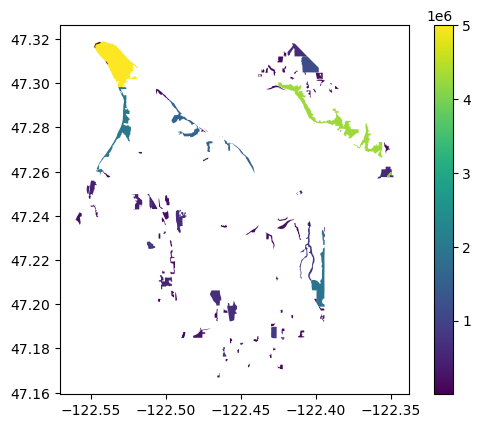

In [40]:
bio_diversity_path = "DART/DARTenvironmental/MapServer/5"
bio_diversity_gpd = get_geojson_as_gp(base_url, bio_diversity_path)
bio_diversity_gpd['bd_area_orig'] = bio_diversity_gpd.to_crs('EPSG:3857').geometry.area
bio_diversity_gpd

bio_diversity_gpd.plot(column='bd_area_orig', cmap='viridis', legend=True)

In [41]:
bd_overlay = bio_diversity_gpd.overlay(subbasins, how='intersection').explode().to_crs('EPSG:3857')
bd_overlay
#bd_overlay.plot()

/var/folders/yn/15903z7124l3th5fm7wg0lgw0000gn/T/ipykernel_49124/1111097915.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  bd_overlay = bio_diversity_gpd.overlay(subbasins, how='intersection').explode().to_crs('EPSG:3857')


,,OBJECTID,Status,bd_area_orig,BASINNAME,SUBBASIN,geometry
0,0,17427,High Probability City of Tacoma Mapped,1.134596e+05,FOSS WATERWAY,FS_08,"POLYGON ((-13630241.941 5980090.440, -13630304..."
1,0,17427,High Probability City of Tacoma Mapped,1.134596e+05,FOSS WATERWAY,FS_09,"POLYGON ((-13629999.492 5980291.087, -13630061..."
2,0,17490,Known City of Tacoma Mapped,1.184755e+05,NORTHEAST TACOMA,NE_01,"POLYGON ((-13628900.706 5992425.259, -13628824..."
3,0,17502,High Probability City of Tacoma Mapped,3.110383e+04,NORTHEAST TACOMA,NE_01,"POLYGON ((-13627411.388 5991515.705, -13627409..."
4,0,17415,High Probability City of Tacoma Mapped,1.519861e+05,NORTHEAST TACOMA,NE_01,"POLYGON ((-13628389.080 5992723.474, -13628355..."
...,...,...,...,...,...,...,...
158,0,17467,Known WDFW Mapped,1.977317e+06,WESTERN SLOPES,WS_02,"POLYGON ((-13641257.880 5985722.064, -13641250..."
159,0,17462,Known City of Tacoma Mapped,6.643434e+05,FLETT CREEK,FL_06,"POLYGON ((-13631834.480 5974656.486, -13631693..."
160,0,17478,High Probability City of Tacoma Mapped,4.177720e+04,FLETT CREEK,FL_08,"POLYGON ((-13631898.022 5972255.980, -13631812..."
161,0,17454,Known City of Tacoma Mapped,2.193018e+05,FOSS WATERWAY,FS_12,"POLYGON ((-13628016.271 5980356.560, -13628118..."


In [42]:
# x = bio_diversity_gpd.to_crs(3857)
# y = subbasins.to_crs(3857)

# biodiv_subbasin = gp.sjoin(x,y, op='intersects').reset_index(drop=True).explode()
# biodiv_subbasin

In [43]:
# y = subbasins.to_crs(3857)
# y['basin_area'] = y.geometry.area
# biodiv_subbasin = gp.overlay(y,x, how='intersection')

# biodiv_subbasin['bd_area'] =biodiv_subbasin.apply(lambda row: row.geometry.area,axis=1)
# biodiv_subbasin['pct_bd'] = biodiv_subbasin['bd_area']/biodiv_subbasin['basin_area']
# biodiv_subbasin.drop(columns=['Status','bd_area','basin_area','OBJECTID','geometry']).to_csv('exported_data/biodiversity_cooridors.csv')

<Axes: >

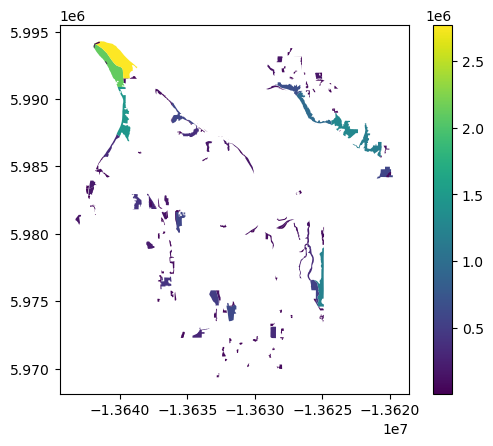

In [44]:
bd_overlay['bd_area'] = bd_overlay.geometry.area
# biodiv_subbasin['bd_in_basin'] = biodiv_subbasin['bd_area']/biodiv_subbasin['basin_area'] 



# Plot the polygons with colors based on area
bd_overlay.plot(column='bd_area', cmap='viridis', legend=True)


<Axes: >

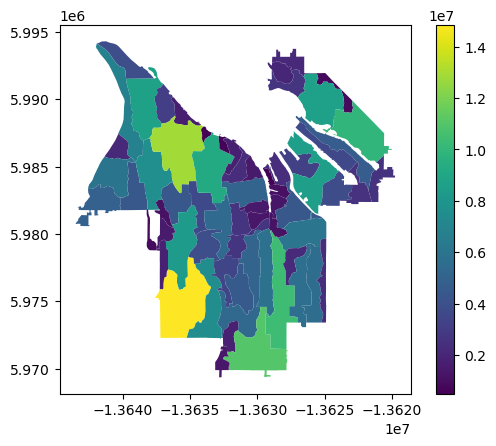

In [51]:
subbasin_area_calc = subbasins[['SUBBASIN', 'geometry']].to_crs('EPSG:3857')

subbasin_area = subbasin_area_calc.dissolve(by='SUBBASIN')
subbasin_area['subbasin_area'] = subbasin_area.geometry.area
subbasin_area
subbasin_area.plot(column='subbasin_area', cmap='viridis', legend=True)

In [52]:
bd_calc = bd_overlay[['SUBBASIN','bd_area']]
bd_calc_df = bd_calc.groupby('SUBBASIN').sum()

In [53]:
bd_summary_df = pd.merge(bd_calc_df, subbasin_area, on='SUBBASIN')
bd_summary_df['Biodiversity'] = bd_summary_df['bd_area'] / bd_summary_df['subbasin_area']
bd_summary_df = bd_summary_df.drop(['bd_area','subbasin_area','geometry'], axis=1)
bd_summary_df

,Biodiversity
SUBBASIN,
FL_01,0.070528
FL_02,0.134872
FL_03,0.049495
FL_04,0.118506
FL_05,0.001061
FL_06,0.010101
FL_07,0.156562
FL_08,0.023346
FL_09,0.026547


In [54]:
#bd_summary_df.to_csv('exported_data/biodiversity.csv', index=False)

Biodiversity Cooridor
150-foot Buffer % vegetated
75-foot Buffer % vegetated
25-foot Buffer % vegetated

# Water Quality
303d (listing) 
TMDL (y/n)

In [4]:
attains_url = 'https://gispub.epa.gov/arcgis/rest/services/OW/ATTAINS_Assessment/MapServer/1' 

In [5]:
feature = subbasins.iloc[0]
geom = list(feature.geometry.exterior.coords)
coord_strings = [f"{x}, {y}" for x, y in geom]

NameError: name 'subbasins' is not defined

In [57]:
tacoma_bbox ="-122.66645777315975, 47.066727220416695, -122.24485743136287, 47.353125316075044"

In [6]:
#{

tacoma_bbox = [   -124.81791282934638,
        46.593055784134464
      
        -120.65459447215042,

     
        49.00245266588554]
     

#tacoma_bbox ="-122.66645777315975, 47.066727220416695, -122.24485743136287, 47.353125316075044"

In [7]:
# From 
# https://gis.stackexchange.com/questions/427434/query-feature-service-on-esri-arcgis-rest-api-with-python-requests
import urllib.parse

attains_url = 'https://gispub.epa.gov/arcgis/rest/services/OW/ATTAINS_Assessment/MapServer/1/query?'

params = {
    'geometry':tacoma_bbox,
    'geometryType': 'esriGeometryEnvelope',
    'inSR': '4326',
    'returnGeometry': 'true', 
    'outFields': 'assessmentunitidentifier,assessmentunitname,tas303d,reportingcycle,waterbodyreportlink,ircategory',
    'f': 'geojson'
}

url_final = attains_url + urllib.parse.urlencode(params)
url_final

'https://gispub.epa.gov/arcgis/rest/services/OW/ATTAINS_Assessment/MapServer/1/query?geometry=%5B-124.81791282934638%2C+-74.06153868801596%2C+49.00245266588554%5D&geometryType=esriGeometryEnvelope&inSR=4326&returnGeometry=true&outFields=assessmentunitidentifier%2Cassessmentunitname%2Ctas303d%2Creportingcycle%2Cwaterbodyreportlink%2Circategory&f=geojson'

In [59]:
 wq_lines = gp.read_file(url_final,driver="GeoJSON")

In [60]:
#get intersecting water quality lines 

water_quality = gp.overlay(wq_lines, subbasins, how='intersection')


In [61]:
wq_df = water_quality.drop(columns=['geometry','BASINNAME'])
wq_df

,assessmentunitidentifier,assessmentunitname,tas303d,reportingcycle,waterbodyreportlink,ircategory,SUBBASIN
0,WA17110014000547_001_001,SWAN CREEK,Y,2018,https://mywaterway.epa.gov/waterbody-report/WA...,3,LP_02
1,WA17110014005448_001_001,CLEAR CREEK,Y,2018,https://mywaterway.epa.gov/waterbody-report/WA...,4A,LP_02
2,WA17110014000548_001_001,SWAN CREEK,Y,2018,https://mywaterway.epa.gov/waterbody-report/WA...,4A,LP_02
3,WA17110019020821_001_001,FIFE DITCH,Y,2018,https://mywaterway.epa.gov/waterbody-report/WA...,5,NE_05
4,WA17110014000548_001_001,SWAN CREEK,Y,2018,https://mywaterway.epa.gov/waterbody-report/WA...,4A,LP_06
5,WA17110019020836_001_001,WAPATO CREEK,Y,2018,https://mywaterway.epa.gov/waterbody-report/WA...,5,TF_05
6,WA17110019020834_001_001,WAPATO CREEK,Y,2018,https://mywaterway.epa.gov/waterbody-report/WA...,5,TF_05


In [80]:
# Save as CSV without geometry column
wq_df.to_csv('waterquality.csv', index=False)

# Stormwater Influence 

* Number of of discharge points (Outfalls)
* Number of of Ditches
* Number of of Culvert Crossings

In [64]:
discharge_pts_path = "ES/SurfacewaterNetwork/MapServer/24"
#ditches_path = "ES/SurfacewaterNetwork/MapServer/30"

In [65]:
discharge_pts = get_geojson_as_gp(base_url,discharge_pts_path)
#ditches = get_geojson_as_gp(base_url,ditches_path)
discharge_pts = discharge_pts[['SUBBASIN','ALTID']]
discharge_pts

,SUBBASIN,ALTID
0,WS_04,SWDP-100001
1,,SWDP-100009
2,TF_05,SWDP-100010
3,,SWDP-100011
4,,SWDP-100012
...,...,...
995,LP_02,SWDP-103010
996,NT_03,SWDP-103011
997,FL_09,SWDP-103012
998,WS_01,SWDP-103013


In [66]:
# Group by the boundary name and count the number of facilities
discharge_pt_count = discharge_pts.groupby('SUBBASIN').size().reset_index(name='discharge_points')
#ditches_count = ditches.groupby('SUBBASIN').size().reset_index(name='ditches_count')

In [67]:
# Drop rows with blank subbasins
discharge_pt_count = discharge_pt_count[(discharge_pt_count['SUBBASIN'] != ' ')]
discharge_pt_count

,SUBBASIN,discharge_points
1,FL_01,5
2,FL_02,28
3,FL_03,19
4,FL_04,4
5,FL_05,17
...,...,...
59,TF_06,15
60,WS_01,7
61,WS_02,1
62,WS_03,11


In [68]:
#ditches_count.to_csv('exported_data/ditches.csv')
#discharge_pt_count.to_csv('exported_data/discharge_pts.csv')

# Urban Heat 

In [69]:
# Get Urban Heat layer 
urban_heat_path = "ES/UrbanHeatIslandIndex/MapServer/0" 
urban_heat = get_geojson_as_gp(base_url,urban_heat_path)
urban_heat.head()

,NAME,pop,income,Total,over65,under14,AF,pm,combtmp,HghRsAG,Density,OBJECTID,Shape.STArea(),Shape.STLength(),GlobalID,geometry
0,"Block Group 3, Census Tract 611, Pierce County...",593,44215,593,45,20,31.168633,29.206090,86.337251,0.109612,0.002024,168,3.156498e+06,7956.465820,{16E2C253-34C2-4EAA-9246-003987418B9C},"POLYGON ((-122.48771 47.24295, -122.48770 47.2..."
1,"Block Group 1, Census Tract 717.04, Pierce Cou...",2795,19143,2795,6,597,32.089511,29.152954,87.118218,0.215742,0.003768,127,7.989632e+06,11694.406135,{F482D4F0-DAE3-4C4A-A21D-018F240524B5},"POLYGON ((-122.47648 47.16231, -122.47631 47.1..."
2,"Block Group 1, Census Tract 9400.11, Pierce Co...",1512,52230,1512,55,101,30.223290,28.698573,85.029676,0.103175,0.000793,59,2.054109e+07,33257.647740,{82AC2989-C48B-4E68-9736-0247A357040F},"POLYGON ((-122.38732 47.27899, -122.38727 47.2..."
3,"Block Group 3, Census Tract 615, Pierce County...",961,30317,961,7,56,30.811586,30.173884,86.886923,0.065557,0.003908,194,2.649048e+06,7135.730545,{7AD3F02E-99E2-4782-9F6A-0499E400ED87},"POLYGON ((-122.44948 47.25645, -122.44939 47.2..."
4,"Block Group 2, Census Tract 629, Pierce County...",966,35094,966,41,60,31.945984,29.144270,86.981229,0.104555,0.001690,79,6.157492e+06,10618.052759,{5352E027-3290-4FE1-8B9D-05E9C069A7CA},"POLYGON ((-122.47364 47.20653, -122.47365 47.2..."


In [70]:
urban_heat_summary = overlay_and_summarize(urban_heat,'pm').reset_index(drop=False)
urban_heat_summary = urban_heat_summary.set_index('SUBBASIN')


In [74]:
#average(x.wt, weights=x.value)
# Calculate the weighted average of 'combtmp' for each 'SUBBASIN'
uh_df = urban_heat_summary.groupby(level='SUBBASIN').apply(lambda x: (x['pm']*x['percent']).sum())

uh_df = (uh_df.rename('Urban_Heat'))
#uh_df.to_csv('exported_data/urban_heat.csv')

In [75]:
uh_df

SUBBASIN
FL_01    29.309959
FL_02    28.856209
FL_03    28.501146
FL_04    28.894393
FL_05    29.299657
           ...    
TF_06    28.703430
WS_01    27.222687
WS_02    27.787339
WS_03    28.316374
WS_04    28.019564
Name: Urban_Heat, Length: 67, dtype: float64

# merge to final list 

In [76]:
dfs = [lu_df,lc_df,dev_age_df,pc_df,
       bd_summary_df,
       uh_df,discharge_pt_count]

In [77]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['SUBBASIN'],
                                            how='outer'), dfs)
df_merged = df_merged.fillna(0)
df_merged

,SUBBASIN,Landuse Airport Compatibility Residential,Landuse Crossroads Mixed-Use Center,Landuse Downtown Regional Growth Center,Landuse General Commercial,Landuse Heavy Industrial,Landuse Light Industrial,Landuse Low-Scale Residential,Landuse Major Institutional Campus,Landuse Mid-Scale Residential,...,Landcover Grass,Landcover Water,Landcover Impervious-roof,Landcover Impervious-nonRoof,Landcover Impervious-total,Age_of_Development,Pavement_Condition,Biodiversity,Urban_Heat,discharge_points
0,FL_01,0.000000,0.000832,0.0,0.042233,0.000000,0.000000,0.584108,0.125021,0.121325,...,0.200049,0.000000,0.177303,0.271577,0.448880,4.992585,59.709062,0.070528,29.309959,5.0
1,FL_02,0.000000,0.055900,0.0,0.000000,0.255416,0.008342,0.119293,0.061759,0.152912,...,0.253896,0.000000,0.106630,0.293404,0.400034,4.961520,60.196544,0.134872,28.856209,28.0
2,FL_03,0.007828,0.000000,0.0,0.043279,0.076765,0.046743,0.365808,0.037940,0.131122,...,0.208548,0.001194,0.154901,0.342242,0.497143,4.942790,65.397895,0.049495,28.501146,19.0
3,FL_04,0.140260,0.000000,0.0,0.050965,0.000000,0.044074,0.349023,0.034867,0.054186,...,0.135653,0.000000,0.177895,0.332157,0.510052,4.992108,61.069765,0.118506,28.894393,4.0
4,FL_05,0.000000,0.000000,0.0,0.108136,0.000000,0.000000,0.585339,0.000000,0.030437,...,0.153857,0.000000,0.174057,0.408878,0.582935,4.998516,59.210819,0.001061,29.299657,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,TF_06,0.000000,0.000000,0.0,0.000000,0.848769,0.000000,0.000000,0.000000,0.000000,...,0.143226,0.070356,0.065008,0.566574,0.631582,4.984439,42.725140,0.000000,28.703430,15.0
63,WS_01,0.000000,0.031092,0.0,0.000000,0.000000,0.000000,0.300343,0.000000,0.048393,...,0.094674,0.014169,0.074944,0.124906,0.199850,4.988112,71.725433,0.539830,27.222687,7.0
64,WS_02,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.721843,0.000000,0.001376,...,0.134472,0.014229,0.165582,0.195104,0.360687,4.999866,74.092165,0.159126,27.787339,1.0
65,WS_03,0.000000,0.020655,0.0,0.000415,0.000000,0.000000,0.620321,0.000341,0.117139,...,0.187090,0.016138,0.163732,0.287242,0.450974,4.940374,62.780553,0.077295,28.316374,11.0


In [79]:
df_merged.to_csv('static_subbasin_metrics.csv')